# Keras Tuner

Keras Tuner es una biblioteca que te ayuda a elegir el conjunto óptimo de hiperparámetros para tu programa TensorFlow/Keras. El proceso de seleccionar el conjunto correcto de hiperparámetros para su aplicación de aprendizaje automático (ML) se llama _hyperparameter tuning_ o _hypertuning_.

Los hiperparámetros son las variables que gobiernan el proceso de entrenamiento y la topología de un modelo de Machine Learning. Estas variables permanecen constantes durante el proceso de entrenamiento e impactan directamente en el rendimiento del programa. Los hiperparámetros puden ser de dos tipos:

* **Hiperparámetros del modelo** que influyen en la selección del modelo, como el número y el ancho de las _hidden layers_
* **Hiperparámetros del algoritmo** que influyen en la velocidad y la calidad del algoritmo de aprendizaje, como la tasa de aprendizaje para el Descenso de Gradiente Estocástico (SGD). 

## 0. Imports

In [29]:
# <-- Machine learning -->
from sklearn.model_selection import train_test_split

# <-- Deep learning -->
import keras
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import optimizers
import keras_tuner as kt

# <-- Analytics -->
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Conjunto de datos

In [30]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

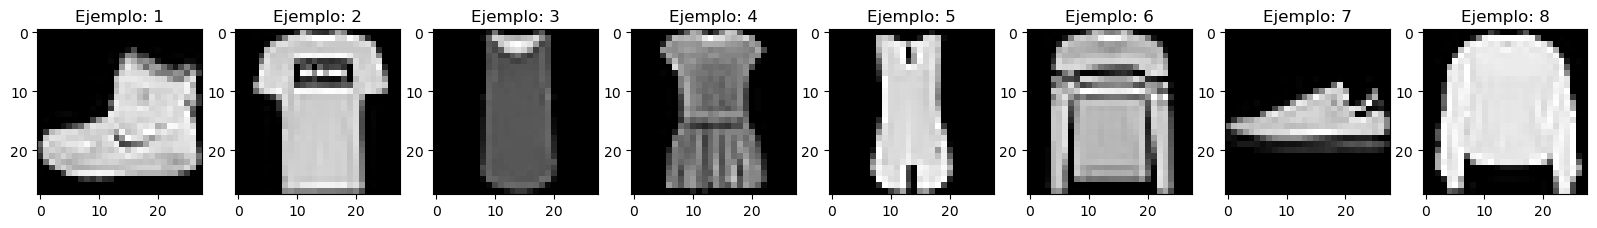

In [31]:
plt.figure(figsize=(20, 4))

for index, e in enumerate(img_train[:8]):
    plt.subplot(1, 8, index+1)
    plt.imshow(e, cmap=plt.cm.gray)
    plt.title('Ejemplo: ' + str(index+1))
    
plt.show()

In [32]:
# Normalizamos el valor de los pixels entre 0 y 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

## 2. Definición del modelo

Cuando se construye un modelo para realizar _hypertuning_, debe definirse el espacio de búsqueda de hiperparámetros además de la arquitectura del modelo. El modelo que estableces para realizar _hypertuning_ se llama _hypermodel_.

Puedes definir un _hypermodel_ a través de dos enfoques:

* Implementando una función que construye el modelo
* Creando una subclase la clase `HyperModel` de la Keras Tuner API

También puedes utilizar dos clases predefinidas de `HyperModel`, `HyperXception` y `HyperResNet` para aplicaciones de visión artificial.

En este tutorial, se implementa una función que construye un modelo de clasificación de imágenes. La función devuelve un modelo compilado y utiliza los hiperparámetros que se definan para realizar _hypertuning_ del mismo.

In [33]:
def model_builder(hp):
    
    # Definición del modelo
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))

    # Primera capa oculta con tunning de unidades y activación
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', values=['relu', 'leaky_relu'])
    model.add(keras.layers.Dense(units=hp_units, activation=hp_activation))
    
    # Segunda capa oculta opcional
    if hp.Boolean('second_layer'):
        hp_units2 = hp.Int('units2', min_value=32, max_value=256, step=32)
        model.add(keras.layers.Dense(units=hp_units2, activation=hp_activation))
    
    # Capa Dropout para regularización
    hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(rate=hp_dropout))

    # Batch Normalization
    model.add(keras.layers.BatchNormalization())
    
    # Ajuste del ratio de aprendizaje
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    # Selección de optimizador
    hp_optimizer = hp.Choice('optimizer', values=['adam','rmsprop'])
    if hp_optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    elif hp_optimizer == 'adamax':
        optimizer = keras.optimizers.Adamax(learning_rate=hp_learning_rate)

    # Compilación del modelo
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    return model

El parámetro `hp` que recibe la función, se corresponde con un objeto de la clase `HyperParameters`, que, de manera general, se corresponde con un "almacén" de hiperparámetros.

## 3. Instanciando el objeto Tuner para realizar _hypertuning_

Una vez definida la función anterior, se instancia el Tuner para realizar el _hypertuning_. El _Keras Tuner_ tiene cuatro _tuners_ disponibles - `RandomSearch`, `Hyperband`, `BayesianOptimization` y `Sklearn`. En este tutorial, se utiliza `Hyperband` (https://arxiv.org/pdf/1603.06560.pdf)

Para instanciar el _tuner_ de Hyperband, hay que especificar el _hypermodel_, el objetivo a optimizar y el número máximo de epochs a entrenar (max_epochs).

In [34]:
tuner = kt.Hyperband(
    model_builder,
    objective = 'val_accuracy', 
    max_epochs = 10,
    factor = 3,
    directory = 'test_dir',
    project_name = 'hp_tuning'
)

Reloading Tuner from test_dir/hp_tuning/tuner0.json


El algoritmo `Hyperband` utiliza la asignación adaptativa de recursos y la detención temprana para converger rápidamente en un modelo de alto rendimiento. El algoritmo entrena un gran número de modelos durante unos pocos epochs y lleva a la siguiente ronda sólo la mitad de los modelos de mayor rendimiento. Hyperband determina el número de modelos a entrenar mediante la fórmula $1 + log_{factor}(max\_epochs)$ y redondea el resultado al entero más cercano.

In [35]:
# Ejecución del tuner para la búsqueda de hiperparámetros
tuner.search(
    img_train, 
    label_train, 
    epochs = 10, 
    validation_data = (img_test, label_test)
)

Una vez que hemos realizado la búsqueda de los hiperparámetros podemos acceder a los valores óptimos mediante la siugiente sentencia

In [36]:
# Obtención de los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Units:", best_hps.get('units'))
print("Learning rate:", best_hps.get('learning_rate'))

Units: 96
Learning rate: 0.001


## 5. Entrenamiento del modelo

Una vez seleccionados los hiperparámetros óptimos, los utilizamos para entrenar el modelo.

In [41]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    img_train,
    label_train,
    epochs = 10,
    validation_data = (img_test, label_test)
)

Epoch 1/10


/Users/cristianariel/miniconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 798us/step - accuracy: 0.4340 - loss: 2.9686 - val_accuracy: 0.5192 - val_loss: 1.5166
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 747us/step - accuracy: 0.4786 - loss: 1.6501 - val_accuracy: 0.5409 - val_loss: 1.3358
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - accuracy: 0.4970 - loss: 1.4519 - val_accuracy: 0.5289 - val_loss: 1.2107
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.4988 - loss: 1.3996 - val_accuracy: 0.5485 - val_loss: 1.1978
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 803us/step - accuracy: 0.4956 - loss: 1.3777 - val_accuracy: 0.5451 - val_loss: 1.2071
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 869us/step - accuracy: 0.5072 - loss: 1.3744 - val_accuracy: 0.5239 - val_loss: 1.2152
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 802us/step - accuracy: 0.4918 - loss: 1.3623 - val_accuracy: 0.5256 - val_loss: 1.1716
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 749us/step - accuracy: 0.4911 - loss: 1.36

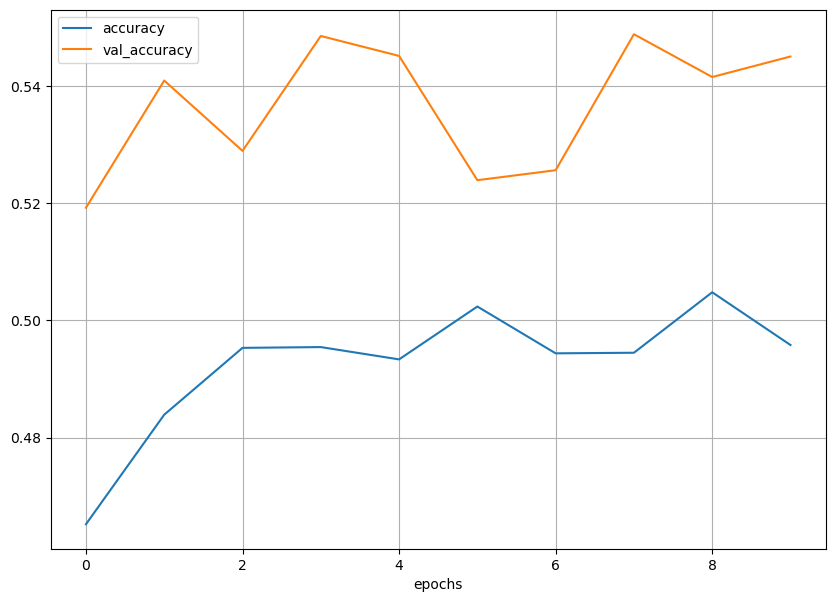

In [42]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 7))
plt.grid(True)
plt.xlabel("epochs")
plt.show()